In [94]:
import gym
from gym import spaces
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [95]:
class StochasticProcess(gym.Env):
    def __init__(self, seed, T):
        super().__init__()
        self.rng = np.random.RandomState(seed)
        self.T = T

    @property
    def state_space(self):
        self._state_space

    @property
    def action_space(self):
        self._action_space

    def seed(self, seed):
        self.rng = np.random.RandomState(seed)
        
    def transition_prob(self, state_t, state_tp1):
        """
        Returns the probability of transitioning from 
        state_t to state_tp1 in the stochastic process
        """
        raise NotImplementedError
    
    def reset(self):
        pass
    
    def reset_task(self):
        self.simulate(self.T)
        
    def simulate(self, T):
        raise NotImplementedError

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [156]:
class RandomWalk(StochasticProcess):
    def __init__(self,
                 dimensions,
                 step_probs,
                 step_sizes,
                 dt=1,
                 seed=10,
                 T=100,
                 n_agents=1):
        """
        :param dimensions: the number of dimensions the problem has
        :param step_probs: list containing 2*dimensions + 1
        :param step_sizes: a list containing 2*dimensions+1 elements of size dimensions
                    indicating the step sizes for each move
        """
        super().__init__(seed, T)
        assert len(step_probs) == 2*dimensions+1, 'You must supply {} step_probs for dimensions'.format(2*dimensions+1, dimensions)
        assert len(step_sizes) == 2*dimensions+1, 'You must supply {} step_sizes for dimensions'.format(2*dimensions+1, dimensions)
        assert sum([len(step_size) == dimensions for step_size in step_sizes]), 'Each element of step_sizes must be of length {}'.format(dimensions)
        assert sum(step_probs) == 1, 'Step probs must sum to 1.'
        self.step_probs = step_probs
        self.dimensions = dimensions
        self.step_sizes = step_sizes
        self.dt = dt
        self.x0 = np.zeros(dimensions)
        self.state = self.x0
        self._state_space = dimensions
        self._action_space = 2*dimensions + 1
        self.n_agents = n_agents
    
    def simulate(self):
        steps_idx = self.rng.multinomial(1, self.step_probs, self.T).argmax(axis=1)
        steps_taken = np.take(self.step_sizes, steps_idx, axis=0)
        self.true_trajectory = steps_taken.cumsum(axis=0)
        self.xT = self.true_trajectory[-1]
        self.global_time_step = 0
        self.reset_agent_locations()
        
    def reset_agent_locations(self):
        self.x_agent = np.repeat(self.xT.reshape(1, self.dimensions), self.n_agents, axis=0)

    def reset(self):
        self.global_time_step = 0
        self.reset_agent_locations()
        return self.x_agent
    
    def new_task(self):
        self.simulate()

    def step(self, actions):
        if self.global_time_step == self.T:
            raise TimeoutError('You have already reached the end of the episode. Use reset()')
        steps_taken = np.take(self.step_sizes, actions.ravel(), axis=0)
        step_log_probs = np.log(np.take(self.step_probs, actions.ravel(), axis=0).reshape(self.n_agents, -1))
        self.x_agent = self.x_agent + steps_taken
        self.global_time_step += 1
        if self.global_time_step == self.T:
            # this will count the agents who reached the correct entry in some state
            corrects = (self.x_agent == self.x0).sum(axis=1)
            # the final log prob is just the sum of getting to the correct
            # position in this space.
            step_log_probs = np.log(corrects * 1/self.dimensions + np.finfo('float').tiny)
        return (self.x_agent, step_log_probs, self.global_time_step == self.T, {})

In [157]:
rw = RandomWalk(2, [1/5, 1/5, 1/5, 1/5, 1/5], [[-1, 0], [0, 0], [1, 0], [0, 1], [-1, -1]], n_agents=1)

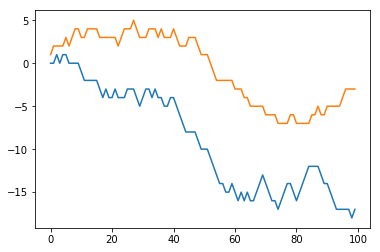

In [158]:
rw.simulate()
plt.plot(rw.true_trajectory)

In [159]:
rw.reset()
rewards = []
for i in range(100):
    actions = np.random.randint(0, 5, size=1).reshape(-1, 1)
    state, reward, done, _ = rw.step(actions)
    rewards.append(reward)

In [162]:
np.vstack(rewards)

array([[  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.60943791],
       [  -1.609